
# Segmenting Glomeruli in EM Stacks

This notebook provides a workflow for segmenting glomeruli in EM stacks using Lazy Painting with LabKit, followed by blob detection and individual glomerulus segmentation. 
    
## 1. Setup and Data Loading

First, let's import the necessary libraries and load our EM stack.

```python
import numpy as np
import tifffile
from scipy import ndimage
from skimage import filters, feature

# Load the EM stack
em_stack = tifffile.imread('path/to/your/em_stack.tif')
print(f"EM stack shape: {em_stack.shape}")
```

In [ ]:
import numpy as np
import tifffile
from scipy import ndimage
from skimage import filters, feature

# Load the EM stack
em_stack = tifffile.imread('path/to/your/em_stack.tif')
print(f"EM stack shape: {em_stack.shape}")


## 2. Downsampling and Smoothing

We'll downsample the stack to reduce computational load and apply smoothing to reduce noise.

```python
# Downsample (e.g., by factor of 2 in each dimension)
downsampled_stack = em_stack[::2, ::2, ::2]

# Apply Gaussian smoothing
smoothed_stack = filters.gaussian(downsampled_stack, sigma=1)

print(f"Smoothed stack shape: {smoothed_stack.shape}")
```



## 3. Lazy Painting with LabKit

Now, we'll use LabKit for lazy painting to create a rough mask of glomeruli. This step is interactive and done through the LabKit GUI.

```python
import labkit

# Launch LabKit GUI
labkit.show(smoothed_stack, title="Segment Glomeruli")

# After manual segmentation, save the mask
glomeruli_mask = labkit.get_segmentation()
tifffile.imwrite('glomeruli_mask.tif', glomeruli_mask)
```

## 4. Blob Detection

Using the mask from LabKit, we'll detect blobs to identify probable glomerular regions.

```python
from skimage.feature import blob_log

# Detect blobs
blobs = blob_log(glomeruli_mask, max_sigma=30, num_sigma=10, threshold=0.1)

print(f"Number of detected blobs: {len(blobs)}")
```

## 5. Segmenting Glomerular Regions

Now, we'll use the detected blobs to segment individual glomerular regions.

```python
def segment_glomeruli(em_stack, blobs, window_size=100):
    segmented_regions = []
    for blob in blobs:
        z, y, x = blob[:3].astype(int)
        r = int(blob[3] * 2)  # Use blob size as region size
        
        # Extract region around the blob
        z_start, z_end = max(0, z-r), min(em_stack.shape[0], z+r)
        y_start, y_end = max(0, y-r), min(em_stack.shape[1], y+r)
        x_start, x_end = max(0, x-r), min(em_stack.shape[2], x+r)
        
        region = em_stack[z_start:z_end, y_start:y_end, x_start:x_end]
        
        # Apply your preferred segmentation method here
        # For example, simple thresholding:
        threshold = filters.threshold_otsu(region)
        segmented_region = region > threshold
        
        segmented_regions.append(segmented_region)
    
    return segmented_regions

# Segment glomeruli
segmented_glomeruli = segment_glomeruli(smoothed_stack, blobs)

print(f"Number of segmented glomeruli: {len(segmented_glomeruli)}")
```

## 6. Visualization and Validation

Finally, let's visualize our results to validate the segmentation.

```python
import napari

viewer = napari.Viewer()
viewer.add_image(smoothed_stack, name='EM Stack')
viewer.add_labels(glomeruli_mask, name='LabKit Mask')

for i, glomerulus in enumerate(segmented_glomeruli):
    viewer.add_labels(glomerulus, name=f'Glomerulus {i+1}')

napari.run()
```



In [3]:
import tifffile
import napari


em_stack = tifffile.imread(r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\bigwarp_alignment\fine_aligned_downsampled_4_em_stack_cropped_woResin_rough_rotated_to_LM.tif')
glomeruli_mask = tifffile.imread(r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\glomeruli_segmentation\segmentation_fine_aligned_downsampled_4_em_stack_cropped_woResin_rough_rotated_to_LM_ds05.tif')

In [2]:
print(em_stack.shape)
print(glomeruli_mask.shape)

(996, 288, 1129)
(498, 144, 565)


In [3]:
viewer = napari.Viewer()
viewer.add_image(em_stack, name='EM stack')
viewer.add_labels(glomeruli_mask, name='Glomeruli mask', scale=(2,2,2))

<Labels layer 'Glomeruli mask' at 0x1b0d0ea7730>

In [16]:
from skimage.feature import blob_log

# Detect blobs
blobs = blob_log(glomeruli_mask, max_sigma=30, num_sigma=10, threshold=0.1)

print(f"Number of detected blobs: {len(blobs)}")

Number of detected blobs: 0


In [30]:
from skimage.transform import rescale 
from skimage.filters import threshold_otsu
ds_glomeruli_mask =  rescale(glomeruli_mask, scale=(0.5,0.5,0.5), anti_aliasing=False)
thresh = threshold_otsu(ds_glomeruli_mask)
ds_glomeruli_mask = ds_glomeruli_mask > thresh
ds_glomeruli_mask.shape
viewer.add_labels(ds_glomeruli_mask, name='Glomeruli mask')

<Labels layer 'Glomeruli mask [6]' at 0x2bf8195f670>

In [90]:
import numpy as np
from sklearn.cluster import DBSCAN
import open3d as o3d

mask_3d = neurites_mask
# Assuming your mask is stored in variable 'mask_3d'
# Convert 3D coordinates to points
x, y, z = np.where(mask_3d == 1)  # Get coordinates of non-zero points
points = np.column_stack((x, y, z))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [91]:
# Create point cloud object
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Perform DBSCAN clustering
eps = 1.2  # Distance threshold
min_points = 10  # Minimum points per cluster
labels = np.array(point_cloud.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))


KeyboardInterrupt



In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5  # Specify desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(points)

In [ ]:
import matplotlib.pyplot as plt

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points colored by cluster
scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                    c=labels, cmap='tab10')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.colorbar(scatter)
plt.show()

In [40]:
# Create empty mask with original dimensions
clustered_mask = np.zeros_like(mask_3d)

# Fill in clusters
for label in np.unique(labels):
    if label != -1:  # Skip noise points (DBSCAN specific)
        cluster_points = points[labels == label]
        clustered_mask[cluster_points[:, 0], 
                      cluster_points[:, 1], 
                      cluster_points[:, 2]] = label + 1

In [ ]:
ob_mask = ...



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

(996, 288, 1129)
(288, 1129)


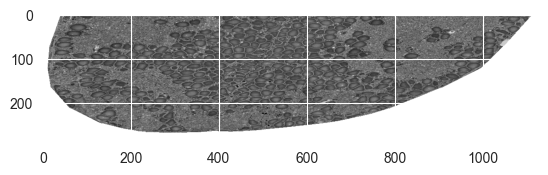

In [5]:
em_stack = tifffile.imread(r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\bigwarp_alignment\fine_aligned_downsampled_4_em_stack_cropped_woResin_rough_rotated_to_LM.tif')
print(em_stack.shape)

img = em_stack[400]
plt.imshow(img, cmap="binary")
print(img.shape)

In [6]:
viewer = napari.Viewer()
viewer.add_image(img, name='EM stack image')


<Image layer 'EM stack image' at 0x1f64a1bd420>

In [7]:
# Initialize training_labels array with zeros
training_labels = np.zeros(img.shape[:2], dtype=np.uint8) # adjust size to match your image
shape_layer_names = [layer.name for layer in viewer.layers if isinstance(layer, napari.layers.Shapes)]
n = 1
for label in shape_layer_names:
    print(f"{label} as label {n}")
    
    # Iterate through shapes
    for shape in viewer.layers[label].data:
        
        shape = np.asarray(shape, dtype=np.int32)

        # For rectangles, the coordinates are stored as corners
        y_min, x_min = np.min(shape, axis=0)
        y_max, x_max = np.max(shape, axis=0)
        
        # Convert to integers
        y_min, y_max = int(y_min), int(y_max)
        x_min, x_max = int(x_min), int(x_max)
        
        # Fill the rectangular region with the shape's label
        training_labels[y_min:y_max, x_min:x_max] = n
    n += 1


cells as label 1
empty as label 2
neurites as label 3


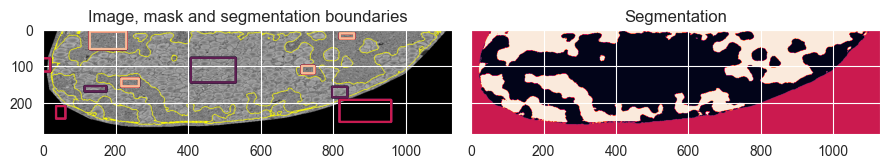

In [8]:
# For 2D 
sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    channel_axis=None,
)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

In [9]:
import tqdm
results_3d = np.zeros_like(em_stack)
for i, slice in enumerate(tqdm.tqdm(em_stack, desc="Processing slices")):
    features_new = features_func(slice)
    results_3d[i] = future.predict_segmenter(features_new, clf)
    

Processing slices: 100%|██████████| 996/996 [08:26<00:00,  1.97it/s]


In [11]:
np.save(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\segmentation\protoglomeruli\training_labels_woResin.svg\results.npy",results_3d)

In [14]:
results_3d = np.load(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\segmentation\protoglomeruli\training_labels_woResin.svg\results.npy", allow_pickle=True)

In [15]:
viewer.add_image(em_stack, name='em_stack')
viewer.add_labels(results_3d)

<Labels layer 'results_3d' at 0x1f60123fd60>

Processing clusters: 100%|██████████| 2522/2522 [01:24<00:00, 29.80it/s]


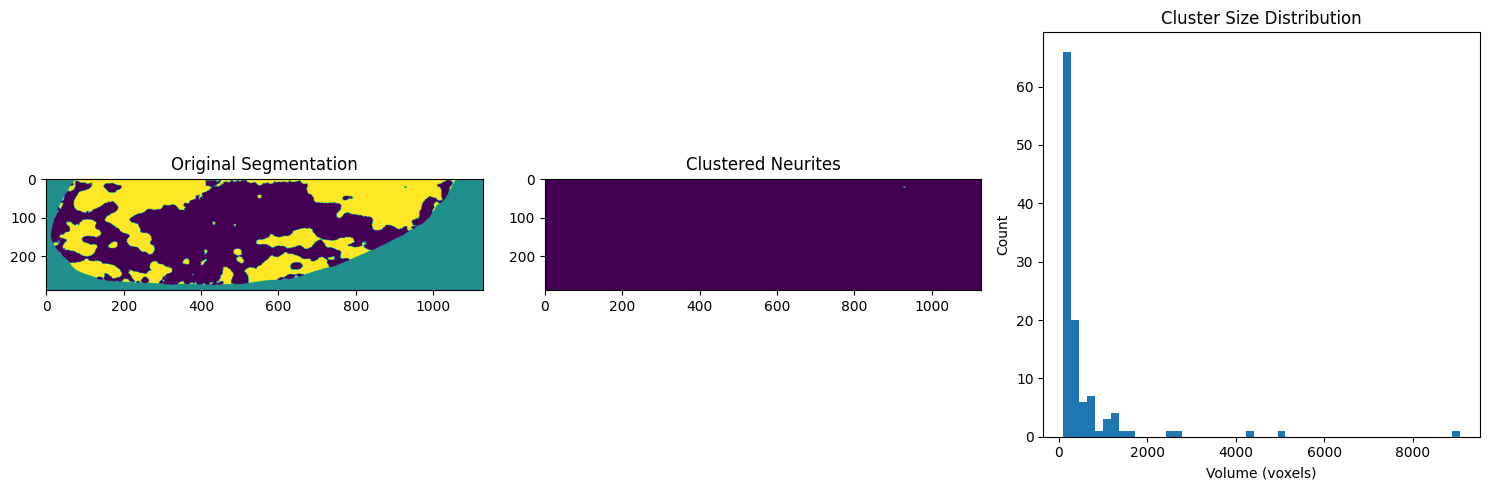

In [71]:
from scipy import ndimage
from skimage.measure import label, regionprops




In [16]:
neurites_mask = np.zeros_like(results_3d)
neurites_mask[results_3d==3] = 1
print(results_3d.shape)
print(neurites_mask.shape)
viewer.add_labels(neurites_mask, name='neurites_mask')

(996, 288, 1129)
(996, 288, 1129)


<Labels layer 'neurites_mask' at 0x1f673980d00>

In [73]:
# Clustering 

from skimage.measure import label, regionprops



1


In [82]:
neurites_label, num  = label(neurites_mask, return_num=True, connectivity=1)
print(num)

20637


In [81]:
viewer.add_labels(neurites_label, name='neurites_label')

<Labels layer 'neurites_label' at 0x26d72fc4460>

In [101]:
from skimage.measure import regionprops
from sklearn.preprocessing import StandardScaler
import numpy as np

def extract_region_features(neurite_mask):
    # Get properties for each connected component
    regions = regionprops(neurite_mask)
    
    # Extract relevant features for each region
    features = []
    for region in regions:
        feature_vector = [
            region.area,                    # Size of the region
            #region.eccentricity,            # Shape elongation
            region.solidity,                # Density of the region
            region.extent,                  # Ratio of pixels to bounding box
            *region.centroid,               # Position information
            region.mean_intensity,          # Intensity features
            region.orientation              # Direction of the major axis
        ]
        features.append(feature_vector)
    
    return np.array(features)
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap

# Extract and scale features
features = extract_region_features(neurites_mask)
scaled_features = StandardScaler().fit_transform(features)

# Apply UMAP for better clustering
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
embedding = reducer.fit_transform(scaled_features)

# Apply DBSCAN clustering
clusterer = DBSCAN(
    eps=0.5,              # Maximum distance between samples
    min_samples=5,        # Minimum samples in a cluster
    metric='euclidean'
)
cluster_labels = clusterer.fit_predict(embedding)
import matplotlib.pyplot as plt

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                     c=cluster_labels, cmap='tab20')
plt.colorbar(scatter)
plt.title('Clustered Glomeruli Regions')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Create labeled image
glomeruli_mask = np.zeros_like(neurites_mask)
regions = regionprops(neurites_mask)
for region, label in zip(regions, cluster_labels):
    if label >= 0:  # Ignore noise points labeled as -1
        glomeruli_mask[region.coords[:, 0], region.coords[:, 1]] = label + 1

# Visualize results
viewer.add_labels(glomeruli_mask, name='glomeruli_clusters')


AttributeError: Attribute 'mean_intensity' unavailable when `intensity_image` has not been specified.

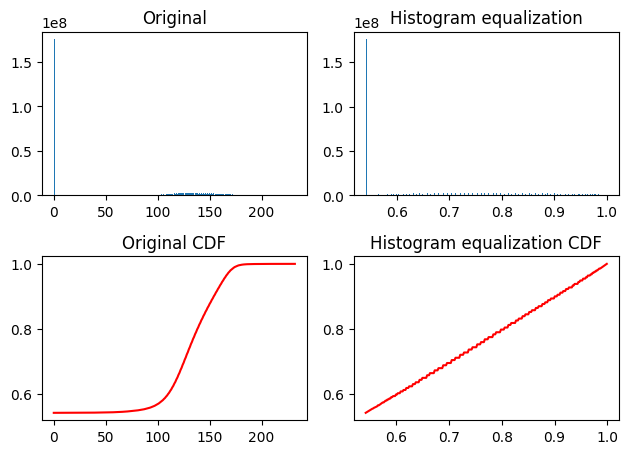

In [103]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
import napari
# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)
nuclei = em_stack        
equalized = exposure.equalize_hist(nuclei)

fig, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2)

plot_hist(a, nuclei, title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = exposure.cumulative_distribution(nuclei.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

fig.tight_layout()

In [104]:
viewer.add_image(equalized, name='equalized')

<Image layer 'equalized' at 0x26d7653ffd0>

In [106]:
viewer.add_image(nuclei, name='nuclei')

<Image layer 'nuclei' at 0x26d7a02fac0>

In [109]:
def stretch_image(image):
    vmin, vmax = np.quantile(image, q=(0.005, 0.995))

    stretched = exposure.rescale_intensity(
        image, 
        in_range=(vmin, vmax), 
        out_range=np.float32
    )
    return stretched

In [105]:

stretched = stretch_image(nuclei)
viewer.add_image(stretched, contrast_limits=[0, 1], name='stretched')

<Image layer 'stretched' at 0x26d79ea3d90>

In [111]:
equalized_stretched = stretch_image(equalized)
viewer.add_image(equalized_stretched, contrast_limits=[0, 1], name='equalized_stretched')

<Image layer 'equalized_stretched' at 0x26d727e84c0>

In [112]:
stretched_equalized = exposure.equalize_hist(stretched)
viewer.add_image(stretched_equalized, contrast_limits=[0, 1], name='stretched_equalized')

<Image layer 'stretched_equalized' at 0x26d79f1d450>

In [113]:
edges = filters.sobel(nuclei)

viewer = napari.view_image(nuclei, blending='additive', colormap='green', name='nuclei')
viewer.add_image(edges, blending='additive', colormap='magenta', name='edges')

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'edges' at 0x26da40affa0>

In [121]:
denoised = ndi.median_filter(equalized, size=3)

In [122]:
viewer.add_image(denoised, name='denoised_equalized')

<Image layer 'denoised_equalized' at 0x26d72d7e410>

In [123]:
li_thresholded = denoised > filters.threshold_li(denoised)

In [124]:
viewer.add_image(li_thresholded, name='thresholded_denoised_equalized', opacity=0.3)

<Image layer 'thresholded_denoised_equalized' at 0x26d7281d150>

In [125]:
filled = ndi.binary_fill_holes(li_thresholded)

viewer.add_image(filled, name='filled', opacity=0.3)

<Image layer 'filled' at 0x26d34bca4a0>

In [126]:
viewer = napari.Viewer()
viewer.add_image(em_stack, name='em_stack')

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'em_stack' at 0x26da40d4af0>

In [127]:
viewer.add_labels(neurites_mask)

<Labels layer 'neurites_mask' at 0x26f1166d780>

In [138]:
print(type(filled[0][0][0]))
print(type(neurites_label[0][0][0]))

<class 'numpy.bool_'>
<class 'numpy.int64'>


In [145]:
neurites_bool = neurites_mask>0
width = 50

remove_holes = morphology.remove_small_holes(
    neurites_bool, 
    area_threshold=width ** 3
)
viewer.add_image(remove_holes, name='remove_holes', opacity=0.3);

In [146]:
width =100

remove_objects = morphology.remove_small_objects(
    remove_holes, 
    min_size=width ** 3
)

viewer.add_image(remove_objects, name='removed_objects', opacity=0.3);

In [147]:
labels = measure.label(remove_objects)

viewer.add_labels(labels, name='labels')

<Labels layer 'labels [1]' at 0x26f25d71870>

In [149]:
transformed = ndi.distance_transform_edt(remove_objects)

maxima = morphology.local_maxima(transformed)
viewer.add_points(np.transpose(np.nonzero(maxima)), name='bad points')

<Points layer 'bad points [1]' at 0x26f25d70bb0>

In [154]:
viewer.layers['bad points'].visible = False
points = viewer.add_points(name='interactive points', ndim=3)
points.mode = 'add'

# now, annotate the centers of the nuclei in your image

In [155]:
marker_locations = points.data

markers = np.zeros(nuclei.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
    edges,
    markers_big, 
    mask=remove_objects
)

viewer.add_labels(segmented, name='segmented')

<Labels layer 'segmented' at 0x26deb8f9900>

In [159]:
# with UMAP
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Reshape the neurite_mask for UMAP
n_samples = neurites_mask.shape[0]  # Get number of samples
reshaped_mask = neurites_mask.reshape((n_samples, -1))  # Flatten each 2D slice

# 2. Scale the data
scaler = StandardScaler()
scaled_mask = scaler.fit_transform(reshaped_mask)

# 3. Apply UMAP
reducer = umap.UMAP(
    n_neighbors=5,     # Small number for local structure
    min_dist=0.1,      # Controls how tightly points are packed
    n_components=2,    # 2D projection
    random_state=42    # For reproducibility
)
embedding = reducer.fit_transform(scaled_mask)

# 4. Visualize results
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50)
plt.title('UMAP projection of neurite_mask')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


AttributeError: module 'umap' has no attribute 'UMAP'

In [138]:
# 1. First view your data
viewer = napari.Viewer()
viewer.add_image(em_stack, name='em_stack')
viewer.add_labels(neurites_mask, name='Original Mask')
# 2. Add a shapes layer for drawing
shapes_layer = viewer.add_shapes(
    name='Exclusion Regions',
    edge_color='red',
    face_color='red',
    opacity=0.3
)

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


In [113]:

# After drawing, convert shapes to mask
def shapes_to_mask(shapes_layer, reference_image):
    # Create empty mask with same shape as reference
    mask = np.zeros_like(reference_image, dtype=bool)
    
    # Convert shapes to mask
    for shape in shapes_layer.data:
        # Get the coordinates of the shape
        coords = np.round(shape).astype(int)
        # Fill the shape region in the mask
        mask[coords[:, 0], coords[:, 1], coords[:, 2]] = True
    
    return mask

# After drawing, create the exclusion mask
exclusion_mask = shapes_to_mask(shapes_layer, neurites_mask)

# Apply the exclusion
masked_neurites = neurites_mask.copy()
masked_neurites[exclusion_mask] = 0


In [114]:
viewer.add_labels(masked_neurites)

<Labels layer 'masked_neurites' at 0x1f6c11ec460>

In [139]:
#Convex hull

from scipy.spatial import ConvexHull
import numpy as np

shapes_data = viewer.layers["Shapes"].data

# 2. Convert shapes to points
points = np.vstack([shape for shape in shapes_data])

# 3. Create convex hull
hull = ConvexHull(points)

# 4. Get hull vertices
hull_vertices = points[hull.vertices]

# 5. Create a new shapes layer with the convex hull
viewer.add_shapes(
    data=[hull_vertices],
    shape_type='polygon',
    edge_color='red',
    face_color='red',
    opacity=0.3,
    name='Convex Hull'
)

# If you want to create a mask from the convex hull
def hull_to_mask(hull_vertices, reference_image):
    mask = np.zeros_like(reference_image, dtype=bool)
    
    # Convert hull vertices to integer coordinates
    vertices = np.round(hull_vertices).astype(int)
    
    # Create polygon mask
    from skimage.draw import polygon
    rr, cc = polygon(vertices[:, 0], vertices[:, 1])
    
    # Keep only valid coordinates
    valid = (
        (rr >= 0) & (rr < reference_image.shape[0]) &
        (cc >= 0) & (cc < reference_image.shape[1])
    )
    mask[rr[valid], cc[valid]] = True
    
    return mask

# Create mask from hull
hull_mask = hull_to_mask(hull_vertices, neurites_mask)

# Apply mask
masked_neurites = neurites_mask.copy()
masked_neurites[~hull_mask] = 0


In [125]:
viewer.layers["Shapes"].data

[array([[119.70547155,  23.06765867, 246.        ],
        [119.70547155,  25.12985586, 246.        ],
        [121.76766874,  25.12985586, 246.        ],
        [121.76766874,  23.06765867, 246.        ]]),
 array([[ 69.38786133,  65.13648032, 246.        ],
        [ 81.76104417,  65.13648032, 246.        ],
        [132.90353324,  56.0628129 , 246.        ],
        [146.10159494,  55.23793405, 246.        ],
        [186.52065888,  55.23793405, 246.        ],
        [222.81532854,  51.93841862, 246.        ],
        [245.08705765,  51.93841862, 246.        ],
        [302.00369871,  63.48672261, 246.        ],
        [316.02663926,  65.13648032, 246.        ],
        [353.97106663,  67.61111689, 246.        ],
        [392.74037286,  77.50966316, 246.        ],
        [412.5374654 ,  84.93357286, 246.        ],
        [436.45895222,  98.13163455, 246.        ],
        [448.00725621, 102.25602883, 246.        ],
        [482.65216815, 117.10384824, 246.        ],
        [5

In [136]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import trimesh

In [137]:

# Get the hull vertices and create triangulation
hull_vertices = points[hull.vertices]

# Create a trimesh mesh from the convex hull
mesh = trimesh.Trimesh(
    vertices=hull_vertices,
    faces=hull.simplices
)

# Ensure the mesh is valid
mesh.fix_normals()

# Convert to format suitable for napari
vertices = mesh.vertices
faces = mesh.faces

# Add to napari
viewer = napari.Viewer()

# Add the points
viewer.add_points(
    points,
    size=2,
    face_color='lightsteelblue',
    opacity=0.5,
    name='Original Points'
)

# Add the surface
viewer.add_surface(
    (vertices, faces),
    name='Hull Surface',
    opacity=0.5,
    colormap='blue',
    shading='flat'
)

# Optional: Add edges
viewer.add_shapes(
    data=[hull_vertices],
    shape_type='polygon',
    edge_color='red',
    face_color='red',
    opacity=0.3,
    name='Hull Edges'
)


IndexError: index 134 is out of bounds for axis 0 with size 86

In [18]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [19]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [20]:
coordinates = np.argwhere(neurites_mask)
coord_df = pd.DataFrame(coordinates, columns=['z', 'y', 'x'])
coord_df.head()

,z,y,x
0,34,1,405
1,34,1,411
2,34,1,412
3,34,3,345
4,34,3,346


In [76]:
coord_df.shape

(54269860, 3)

In [94]:

reduced_coordinates = coord_df.sample(n=5000, random_state=42)
print(reduced_coordinates.shape)

(5000, 3)


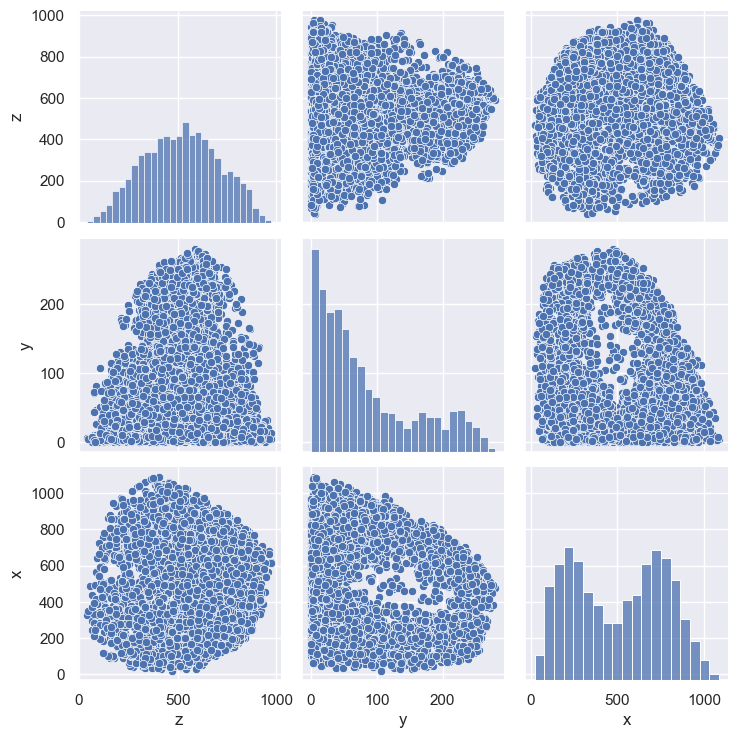

In [95]:
sns.pairplot(reduced_coordinates)

In [97]:
import umap.umap_ as umap
#reducer = umap.UMAP()
reducer = umap.UMAP(
    n_components=3,  # Changed to 3 components
    #random_state=42
)

In [98]:
coords_data = reduced_coordinates.values
scaled_coords_data = StandardScaler().fit_transform(coords_data)

In [100]:
embedding = reducer.fit_transform(scaled_coords_data)
embedding.shape

(5000, 3)

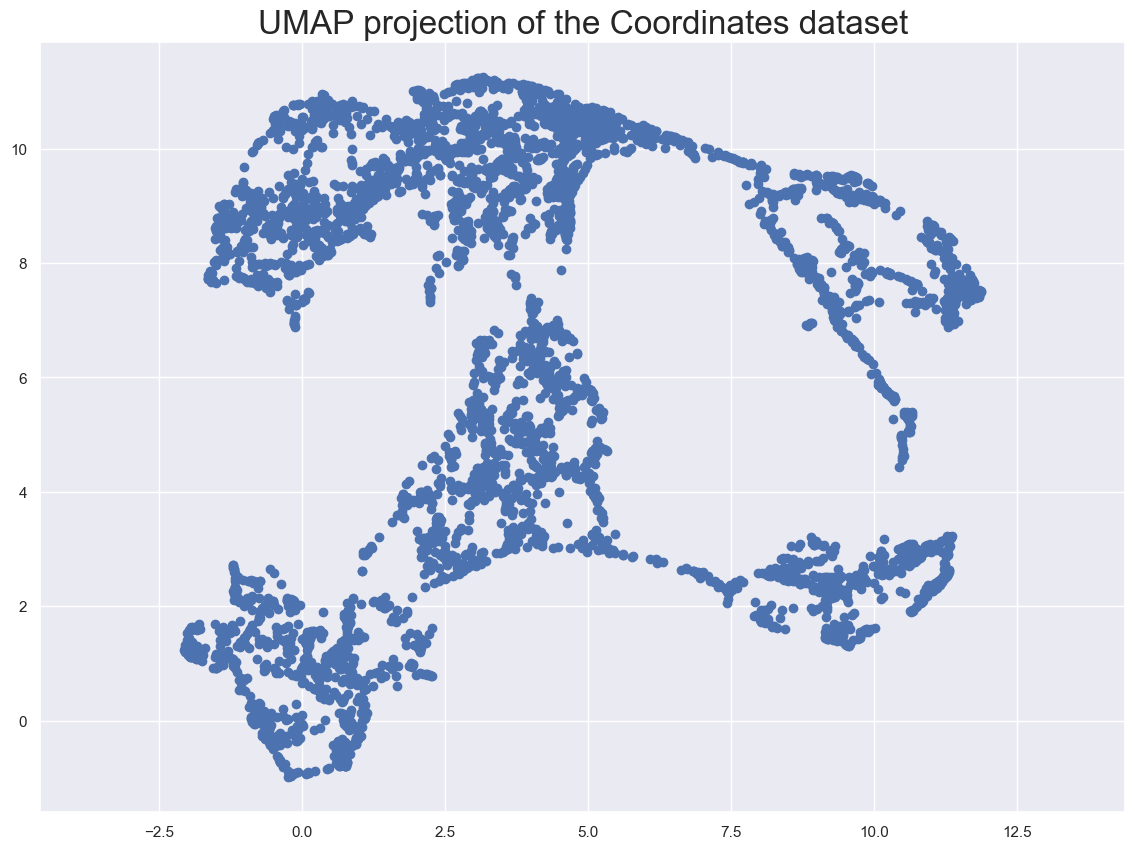

In [101]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
    #c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Coordinates dataset', fontsize=24);

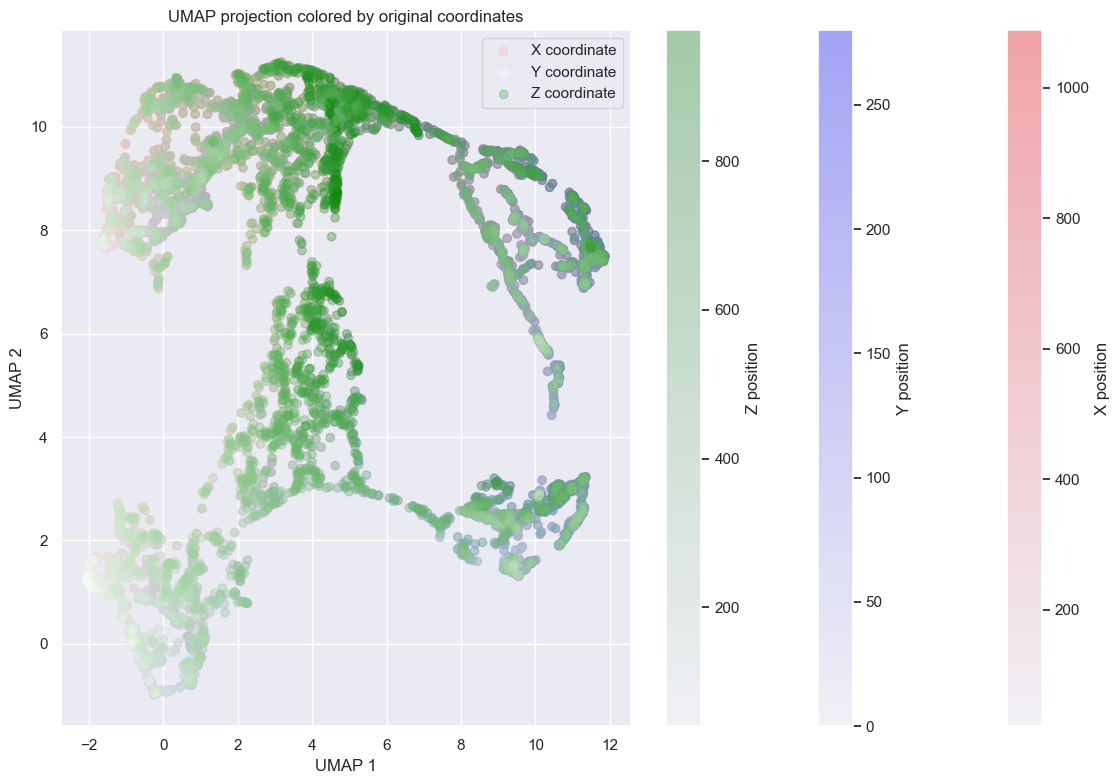

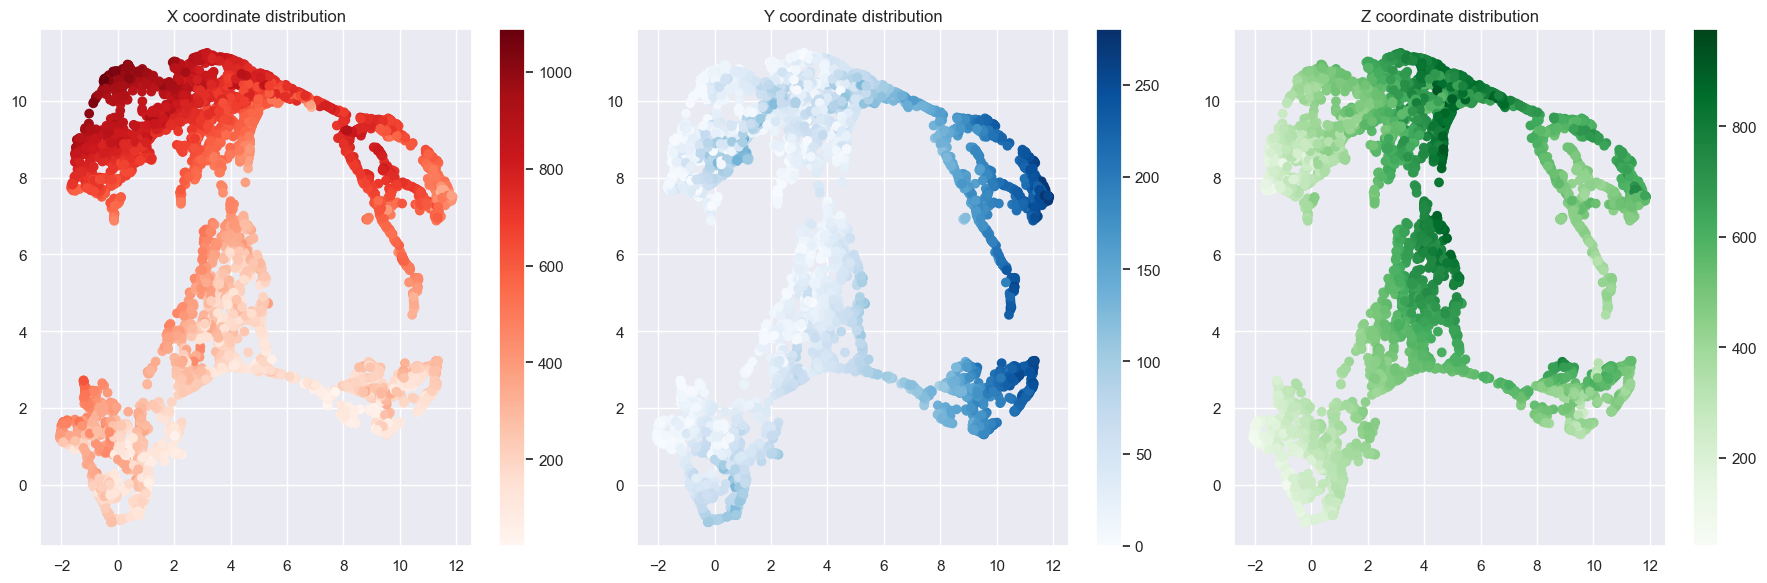

In [102]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming you have:
# reduced_coordinates - your original xyz coordinates
# embedding - your UMAP embedding (the 2D coordinates shown in your plot)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create custom colormaps
red_cmap = LinearSegmentedColormap.from_list('', ['white', 'red'])
blue_cmap = LinearSegmentedColormap.from_list('', ['white', 'blue'])
green_cmap = LinearSegmentedColormap.from_list('', ['white', 'green'])

# Create three separate scatter plots for each dimension
scatter_x = ax.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['x'], 
                      cmap=red_cmap, 
                      alpha=0.3, 
                      label='X coordinate')

scatter_y = ax.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['y'], 
                      cmap=blue_cmap, 
                      alpha=0.3, 
                      label='Y coordinate')

scatter_z = ax.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['z'], 
                      cmap=green_cmap, 
                      alpha=0.3, 
                      label='Z coordinate')

# Add colorbars
plt.colorbar(scatter_x, label='X position')
plt.colorbar(scatter_y, label='Y position')
plt.colorbar(scatter_z, label='Z position')

# Customize plot
plt.title('UMAP projection colored by original coordinates')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Alternative: Create three separate subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# X coordinates
scatter1 = ax1.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['x'], 
                      cmap='Reds')
ax1.set_title('X coordinate distribution')
plt.colorbar(scatter1, ax=ax1)

# Y coordinates
scatter2 = ax2.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['y'], 
                      cmap='Blues')
ax2.set_title('Y coordinate distribution')
plt.colorbar(scatter2, ax=ax2)

# Z coordinates
scatter3 = ax3.scatter(embedding[:, 0], embedding[:, 1], 
                      c=reduced_coordinates['z'], 
                      cmap='Greens')
ax3.set_title('Z coordinate distribution')
plt.colorbar(scatter3, ax=ax3)

plt.tight_layout()
plt.show()


In [65]:
# Add the points layer
points_layer = viewer.add_points(
    embedding,
    size=2,
    name='UMAP 3D',
    opacity=0.8,
    edge_color='white',
    face_color='lightsteelblue'
)


In [ ]:
# First create the 3D UMAP embedding
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,  # Changed to 3 components
    random_state=42
)
embedding_3d = reducer.fit_transform(reduced_coordinates)

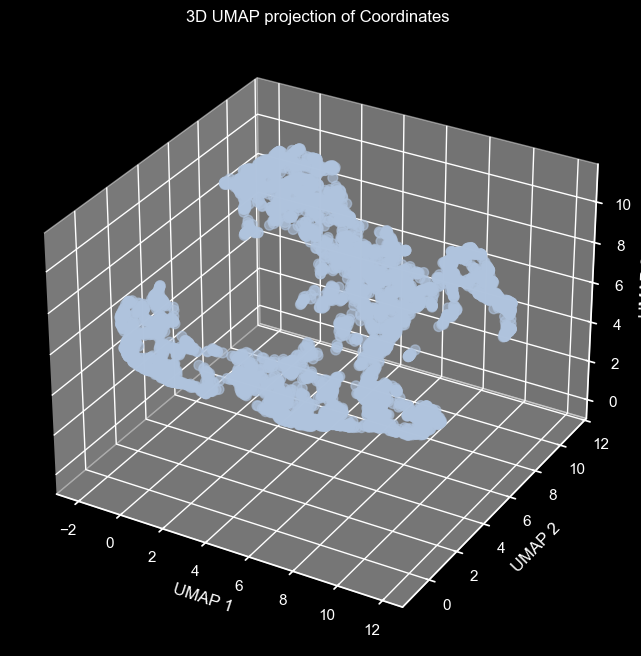

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


ValueError: face_color should be the name of a color, an array of colors, or the name of an property

In [103]:
embedding_3d= embedding
# 1. Matplotlib 3D visualization
plt.style.use("dark_background")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c='lightsteelblue',
    alpha=0.6,
    s=50
)

ax.set_title('3D UMAP projection of Coordinates')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.show()

# 2. Napari visualization
import napari

# Create a new viewer
viewer = napari.Viewer()

# Add the points layer
points_layer = viewer.add_points(
    embedding_3d,
    size=2,
    name='UMAP 3D',
    opacity=0.8,
    edge_color='white',
    face_color='lightsteelblue'
)

# Optional: Add color based on original coordinates
points_layer.face_color = reduced_coordinates  # This will color points based on their original positions

# Show the viewer (not needed if you're in a Jupyter notebook)
napari.run()


In [ ]:
#DSCAN

from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Perform clustering on UMAP embedding
clustering = DBSCAN(eps=0.5, min_samples=50)
cluster_labels = clustering.fit_predict(embedding)

# Generate a colormap with distinct colors (one for each cluster)
n_clusters = len(np.unique(cluster_labels))
print(n_clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_cmap = ListedColormap(colors)

# 2. Plot UMAP with cluster colors
plt.figure(figsize=(12, 8))
plt.style.use("dark_background")

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                     c=cluster_labels, 
                     cmap=cluster_cmap,
                     s=50,
                     alpha=0.8)

plt.colorbar(scatter, label='Cluster')
plt.title('UMAP projection with clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# 3. Plot 3D UMAP with cluster colors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding_3d[:, 0],
                    embedding_3d[:, 1],
                    embedding_3d[:, 2],
                    c=cluster_labels,
                    cmap=cluster_cmap,
                    s=50,
                    alpha=0.8)

plt.colorbar(scatter, label='Cluster')
ax.set_title('3D UMAP projection with clusters')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.show()

# 4. Visualize in original coordinate space using napari
import napari

viewer = napari.Viewer()

# Add points colored by cluster
points_layer = viewer.add_points(
    reduced_coordinates,
    size=2,
    face_color=[colors[label] if label != -1 else [0,0,0,1] for label in cluster_labels],
    edge_color='white',
    opacity=0.8,
    name='Clustered Points'
)

# Optional: Add the original volume for reference
if 'neurite_mask' in locals():
    viewer.add_image(neurites_mask, opacity=0.5, colormap='gray')

napari.run()



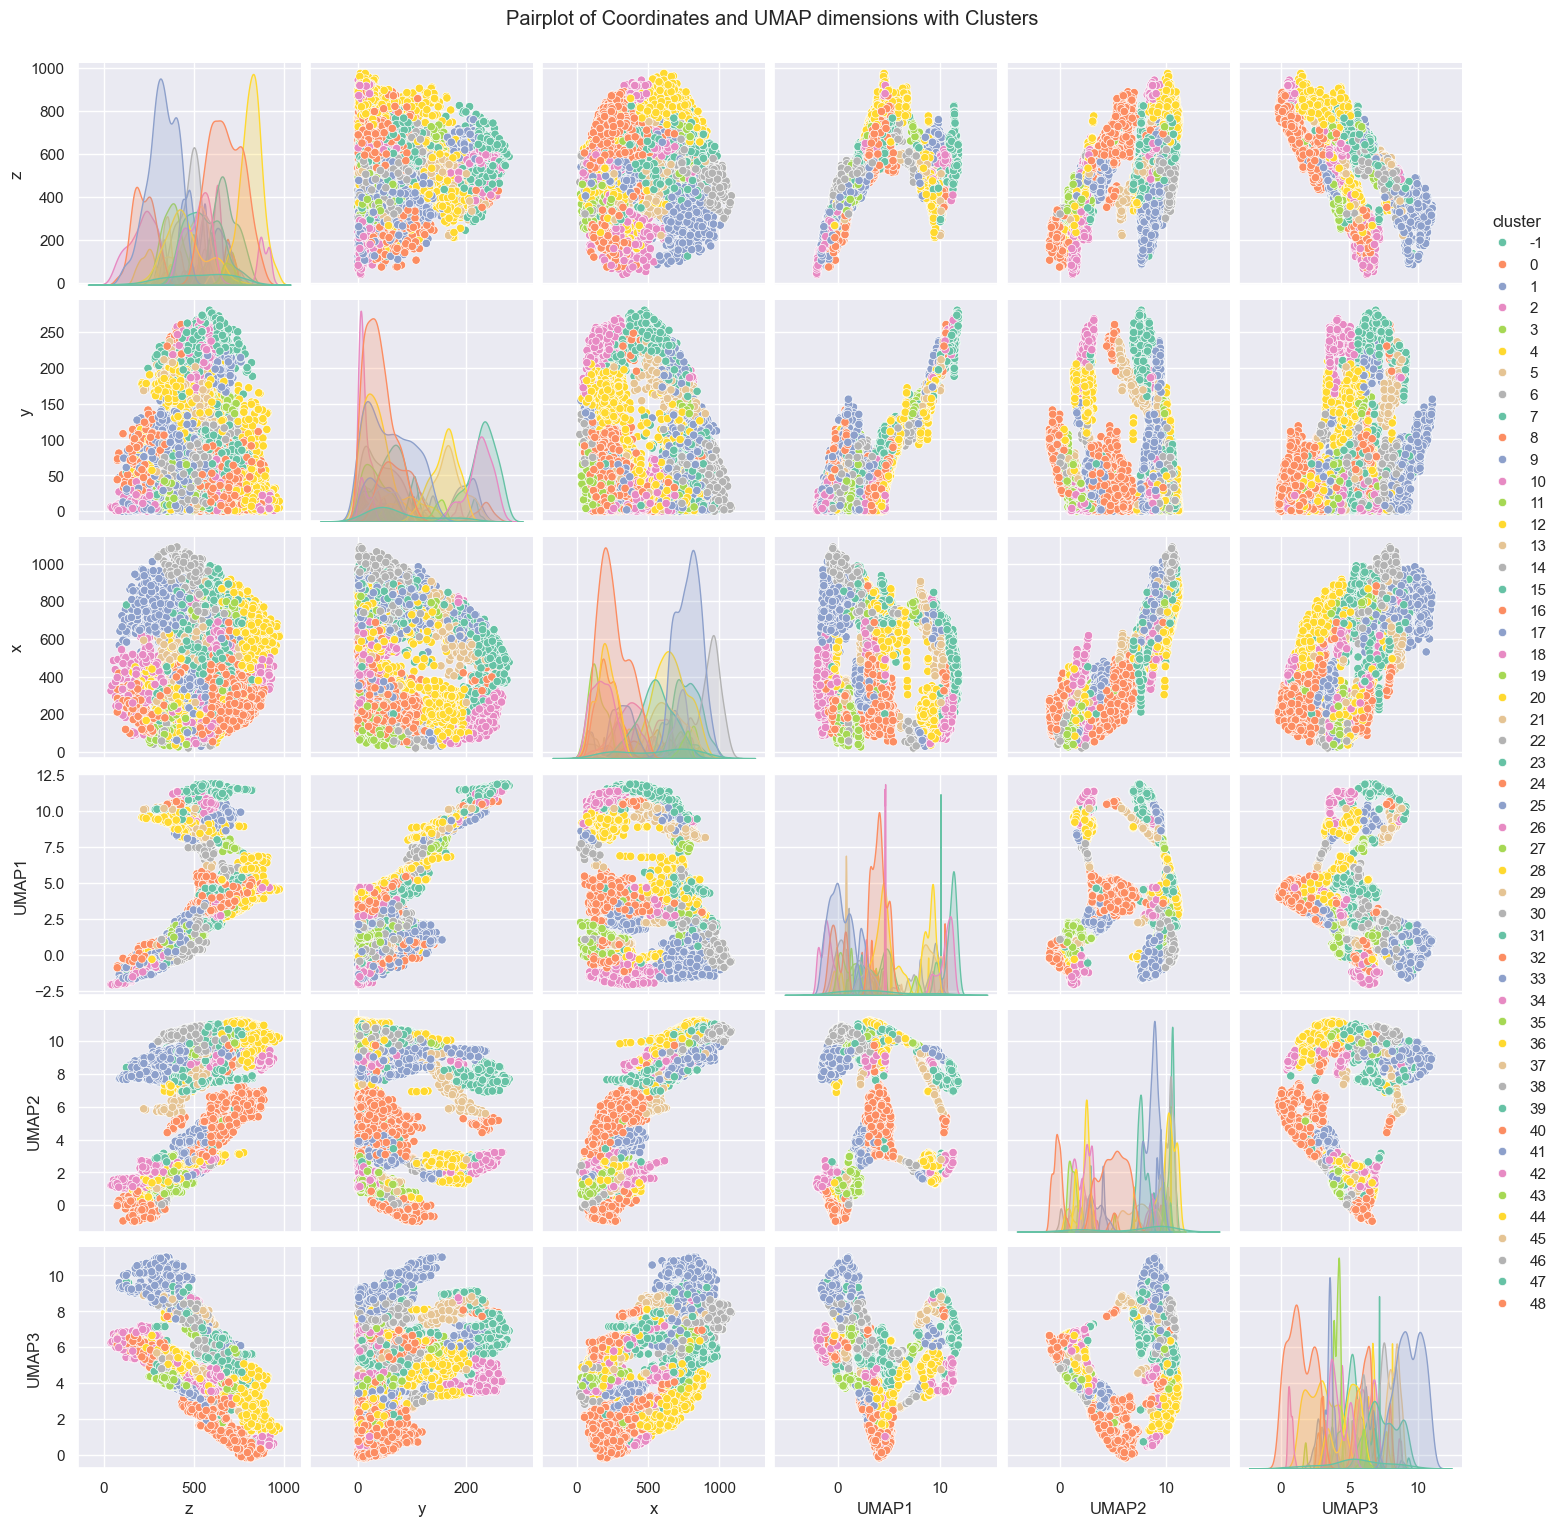


Cluster Statistics:


KeyError: 'cluster'

In [104]:
# Add UMAP coordinates to the DataFrame
reduced_coordinates['UMAP1'] = embedding_3d[:, 0]
reduced_coordinates['UMAP2'] = embedding_3d[:, 1]
reduced_coordinates['UMAP3'] = embedding_3d[:, 2]

# Perform clustering on UMAP coordinates
clustering = DBSCAN(eps=0.3, min_samples=5)
cluster_labels = clustering.fit_predict(embedding)

# Add cluster labels to DataFrame
reduced_coordinates['cluster'] = cluster_labels

# Create pairplot with both original coordinates and UMAP dimensions
sns.set_theme(style='darkgrid')
pairplot = sns.pairplot(reduced_coordinates, 
                       vars=['z', 'y', 'x', 'UMAP1', 'UMAP2', 'UMAP3'],  # specify columns to plot
                       hue='cluster',
                       palette='Set2',  # you can change the color palette
                       diag_kind='kde')  # kernel density estimation for diagonal plots

plt.suptitle('Pairplot of Coordinates and UMAP dimensions with Clusters', y=1.02)
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
print(coord_df['cluster'].value_counts())


In [107]:
import numpy as np
import napari

# 1. Create a mapping between reduced coordinates and cluster labels
coordinate_to_cluster = {}
for coord, cluster in zip(reduced_coordinates.values, cluster_labels):
    coordinate_to_cluster[tuple(coord)] = cluster

# 2. Create a new mask with the same shape as the original
clustered_mask = np.zeros_like(neurites_mask, dtype=np.int32)

# 3. Map clusters back to original coordinates
coordinates = np.argwhere(neurites_mask)
for coord in coordinates:
    # Convert to tuple for dictionary lookup
    coord_tuple = tuple(coord)
    # If this coordinate was in our reduced set, assign its cluster
    if coord_tuple in coordinate_to_cluster:
        clustered_mask[coord_tuple] = coordinate_to_cluster[coord_tuple]

# 4. Visualize in napari
viewer = napari.Viewer()

# Add original mask
viewer.add_image(neurites_mask, name='Original Mask', opacity=0.5)

# Add clustered mask with a colormap
viewer.add_labels(
    clustered_mask, 
    name='Clustered Mask',
    opacity=0.7
)

# Optional: Add the reduced points for reference
viewer.add_points(
    reduced_coordinates,
    size=2,
    face_color='cluster',
    edge_color='white',
    opacity=0.8,
    name='Sample Points'
)

napari.run()


KeyboardInterrupt: 

In [109]:
from scipy.spatial import cKDTree
import numpy as np

# 1. Make sure reduced_coordinates and original coordinates have the same dimensions
print("Reduced coordinates shape:", reduced_coordinates.shape)  # Should be (500, 3)
print("Original coordinates shape:", np.argwhere(neurites_mask).shape)  # Will be (N, 3)

# 2. Build KDTree from reduced coordinates with the correct dimensions
# Convert DataFrame to numpy array if needed
reduced_coords_array = reduced_coordinates[['z', 'y', 'x']].values
tree = cKDTree(reduced_coords_array)

# 3. Get original coordinates
original_coords = np.argwhere(neurites_mask)

# 4. Find nearest neighbors
distances, indices = tree.query(original_coords, k=1)

# 5. Create clustered mask
clustered_mask = np.zeros_like(neurites_mask, dtype=np.int32)
clustered_mask[tuple(original_coords.T)] = cluster_labels[indices]

# 6. Visualize
viewer = napari.Viewer()
viewer.add_image(neurites_mask, name='Original Mask', opacity=0.5)
viewer.add_labels(clustered_mask, name='Clustered Mask', opacity=0.7)

# Optional: Add the reduced points for reference
viewer.add_points(
    reduced_coords_array,
    size=2,
    face_color=[plt.cm.tab20(i) for i in cluster_labels],
    edge_color='white',
    opacity=0.8,
    name='Sample Points'
)

napari.run()


Reduced coordinates shape: (5000, 7)
Original coordinates shape: (54269860, 3)


D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)
